## Original Embedding

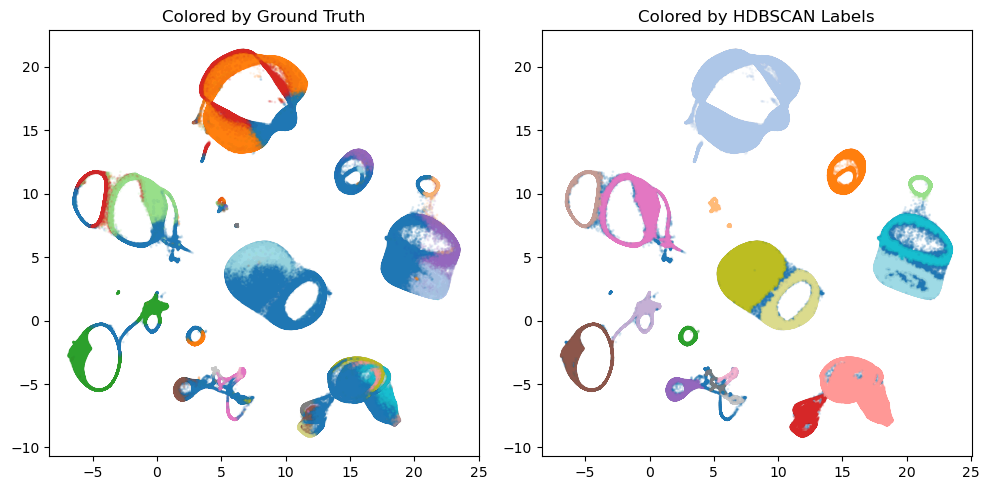

In [13]:
import numpy as np
import matplotlib.pyplot as plt


f = np.load("/Users/georgev/Downloads/llb16_raw_false.npz")

embedding = f["embedding_outputs"]
neural_states = f["predictions"]
ground_truth = f["ground_truth_labels"]
hdbscan_labels = f["hdbscan_labels"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sc0 = axes[0].scatter(embedding[:, 0], embedding[:, 1], c=ground_truth, cmap="tab20", alpha=0.1, s=1)
axes[0].set_title("Colored by Ground Truth")

sc1 = axes[1].scatter(embedding[:, 0], embedding[:, 1], c=hdbscan_labels, cmap="tab20", alpha=0.1, s=1)
axes[1].set_title("Colored by HDBSCAN Labels")

plt.tight_layout()
plt.show()


In [14]:
print(np.unique(ground_truth, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), array([390610,  46887,  34722,   6689, 122818,   7533,  22950,  47902,
        68702,  21937,  47574,  10394,  15658,  36030,   1407,   8047,
         3355,   2866,   2518,   6216,   2440,   1429,   1151,   1806,
         1486,   7089,   8000,  11889,   5825,  55527,   1009]))


## Balanced By Ground Truth Labels Weird Eucledian Distance Collapse To Point Wise

[390610  46887  34722   6689 122818   7533  22950  47902  68702  21937
  47574  10394  15658  36030   1407   8047   3355   2866   2518   6216
   2440   1429   1151   1806   1486   7089   8000  11889   5825  55527
   1009]


/Users/georgev/anaconda3/envs/tweetybert/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgev/anaconda3/envs/tweetybert/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgev/anaconda3/envs/tweetybert/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


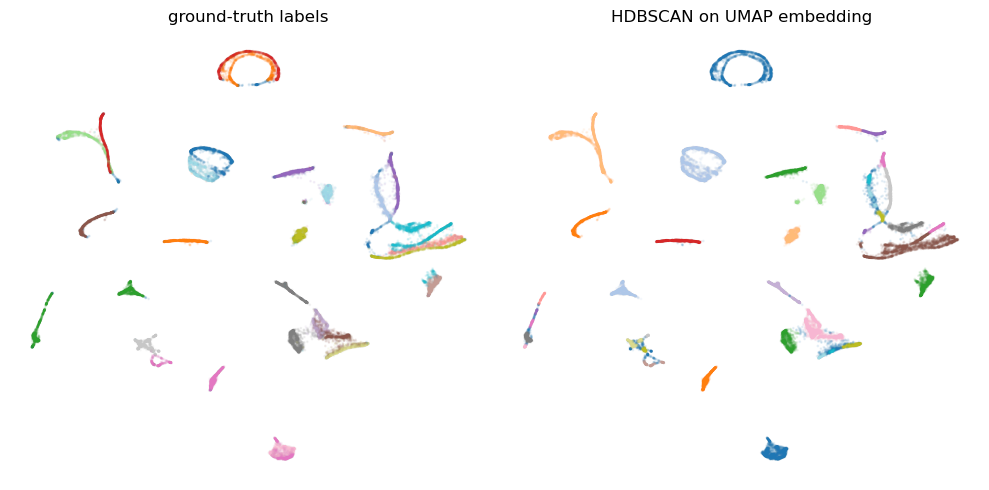

In [22]:
import numpy as np
import umap
import matplotlib.pyplot as plt

# ── load ----------------------------------------------------------------------
f              = np.load("/Users/georgev/Downloads/llb16_raw_false.npz")
X              = f["predictions"]          # (N, D)
y_true         = f["ground_truth_labels"]
hdb_labels     = f["hdbscan_labels"]       # from your first pass

# ── build a BALANCED core set, one quota per GROUND TRUTH label -------------------
unique_labels, cnts = np.unique(y_true, return_counts=True)

print(cnts)

quota          = cnts.min()                # rarest ground truth label size
rng            = np.random.default_rng(42)

core_idx = np.hstack([
    rng.choice(np.where(y_true == c)[0], size=quota, replace=False)
    for c in unique_labels
])

# (optional) randomize order inside the core set
perm           = rng.permutation(len(core_idx))
core_idx       = core_idx[perm]

# ── slice *everything* with the same indices ----------------------------------
X_core         = X[core_idx]
y_core         = y_true[core_idx]
hdb_core       = hdb_labels[core_idx]

# ── keep only the first 100 000 if desired -------------------------------------
X_core   = X_core[:100_000]
y_core   = y_core[:100_000]
hdb_core = hdb_core[:100_000]

# ── fit UMAP on the balanced core ---------------------------------------------
x = umap.UMAP(
        n_neighbors=200,
        min_dist=0.1,
        metric="correlation"
    ).fit_transform(X_core)

# ── apply HDBSCAN to the new embedding ----------------------------------------
import hdbscan
hdbscan_new = hdbscan.HDBSCAN(min_cluster_size=50)
hdb_labels_new = hdbscan_new.fit_predict(x)

# ── viz -----------------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x[:, 0], x[:, 1], c=y_core,  cmap="tab20", s=1, alpha=0.08)
ax[0].set_title("ground-truth labels")
ax[0].axis("off")

ax[1].scatter(x[:, 0], x[:, 1], c=hdb_labels_new, cmap="tab20", s=1, alpha=0.08)
ax[1].set_title("HDBSCAN on UMAP embedding")
ax[1].axis("off")

plt.tight_layout()
plt.show()


## Balance By HDBSCAN Labels

[218998  44592   6122  11116  13750  28450  88878  18524  27017  57252
  28883  95351   6980   5183   7511 114526  76879  68423  69076]
(98477, 196)


/Users/georgev/anaconda3/envs/tweetybert/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgev/anaconda3/envs/tweetybert/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgev/anaconda3/envs/tweetybert/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


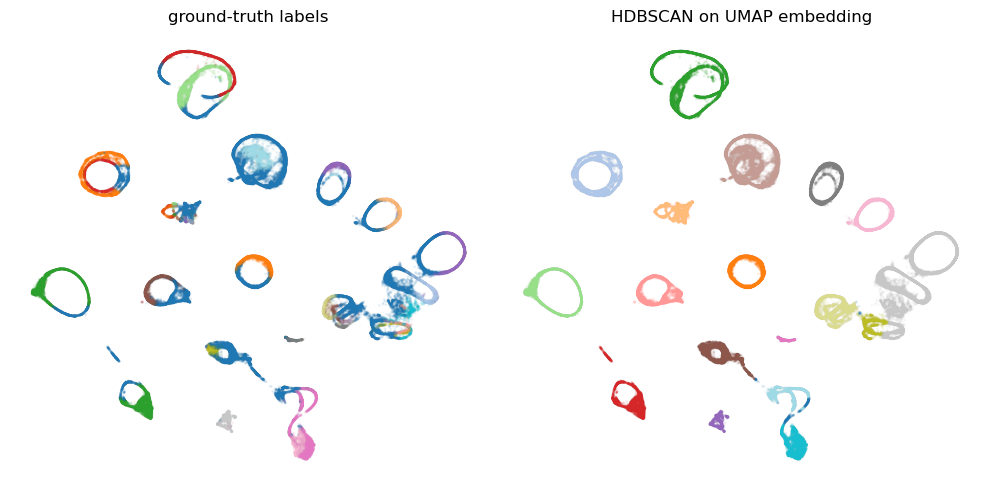

In [ ]:
import numpy as np
import umap
import matplotlib.pyplot as plt

# ── load ----------------------------------------------------------------------
f              = np.load("/Users/georgev/Downloads/llb16_raw_false.npz")
X              = f["predictions"]          # (N, D)
y_true         = f["ground_truth_labels"]
hdb_labels     = f["hdbscan_labels"]       # from your first pass

# ── build a BALANCED core set, one quota per HDBSCAN cluster -------------------
mask_clusters  = hdb_labels != -1
clusters, cnts = np.unique(hdb_labels[mask_clusters], return_counts=True)

print(cnts)

quota          = cnts.min()                # rarest cluster size
rng            = np.random.default_rng(42)

core_idx = np.hstack([
    rng.choice(np.where(hdb_labels == c)[0], size=quota, replace=False)
    for c in clusters
])

# (optional) randomize order inside the core set
perm           = rng.permutation(len(core_idx))
core_idx       = core_idx[perm]

# ── slice *everything* with the same indices ----------------------------------
X_core         = X[core_idx]
y_core         = y_true[core_idx]
hdb_core       = hdb_labels[core_idx]

# ── keep only the first 50 000 if desired -------------------------------------
X_core   = X_core[:100_000]
y_core   = y_core[:100_000]
hdb_core = hdb_core[:100_000]

print(X_core.shape)

# ── fit UMAP on the balanced core ---------------------------------------------
x = umap.UMAP(
        n_neighbors=100,
        min_dist=0.1,
        metric="braycurtis"
    ).fit_transform(X_core)

# ── apply HDBSCAN to the new embedding ----------------------------------------
import hdbscan
hdbscan_new = hdbscan.HDBSCAN(min_cluster_size=500)
hdb_labels_new = hdbscan_new.fit_predict(x)

# ── viz -----------------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x[:, 0], x[:, 1], c=y_core,  cmap="tab20", s=1, alpha=0.08)
ax[0].set_title("ground-truth labels")
ax[0].axis("off")

ax[1].scatter(x[:, 0], x[:, 1], c=hdb_labels_new, cmap="tab20", s=1, alpha=0.08)
ax[1].set_title("HDBSCAN on UMAP embedding")
ax[1].axis("off")

plt.tight_layout()
plt.show()


# random 50 k + inverse-frequency sample_weight

/home/george-vengrovski/anaconda3/envs/tweetybert/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


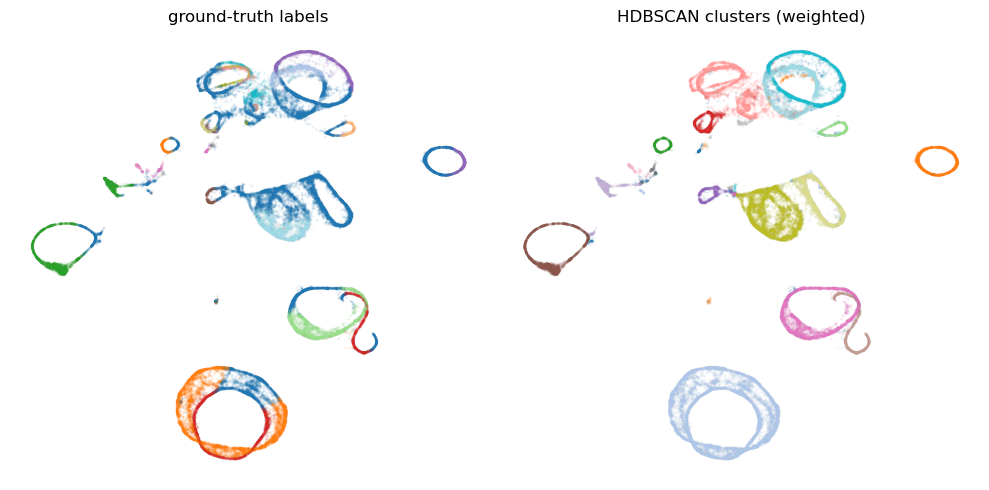

In [3]:
import numpy as np
import umap
import matplotlib.pyplot as plt

# ── load ───────────────────────────────────────────────────────────────────────
f          = np.load("files/llb16_raw_false.npz")
X          = f["predictions"]
y_true     = f["ground_truth_labels"]
hdb_labels = f["hdbscan_labels"]

rng        = np.random.default_rng(42)

# ── draw a random 50 k subset ─────────────────────────────────────────────────
idx        = rng.choice(len(X), size=50_000, replace=False)
X_sub      = X[idx]
y_sub      = y_true[idx]
hdb_sub    = hdb_labels[idx]

# ── inverse-frequency weights *per HDBSCAN cluster* ───────────────────────────
shift_full = hdb_labels + 1          # map −1→0 so bincount works
freq_full  = np.bincount(shift_full) # global cluster frequencies

shift_sub  = hdb_sub + 1
weights    = 1.0 / freq_full[shift_sub]
weights   /= weights.mean()          # normalise around 1

# optional: down-weight noise points (cluster −1)
# weights[shift_sub == 0] *= 0.1

# ── UMAP ──────────────────────────────────────────────────────────────────────
u = umap.UMAP(
        n_neighbors=200,
        min_dist=0.1,
        metric="cosine",
        random_state=42
    )
x = u.fit_transform(X_sub, sample_weight=weights)

# ── viz ───────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x[:, 0], x[:, 1], c=y_sub,  cmap="tab20", s=1, alpha=0.08)
ax[0].set_title("ground-truth labels")
ax[0].axis("off")

ax[1].scatter(x[:, 0], x[:, 1], c=hdb_sub, cmap="tab20", s=1, alpha=0.08)
ax[1].set_title("HDBSCAN clusters (weighted)")
ax[1].axis("off")

plt.tight_layout()
plt.show()

## oversample to a perfectly balanced 50 k

/home/george-vengrovski/anaconda3/envs/tweetybert/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


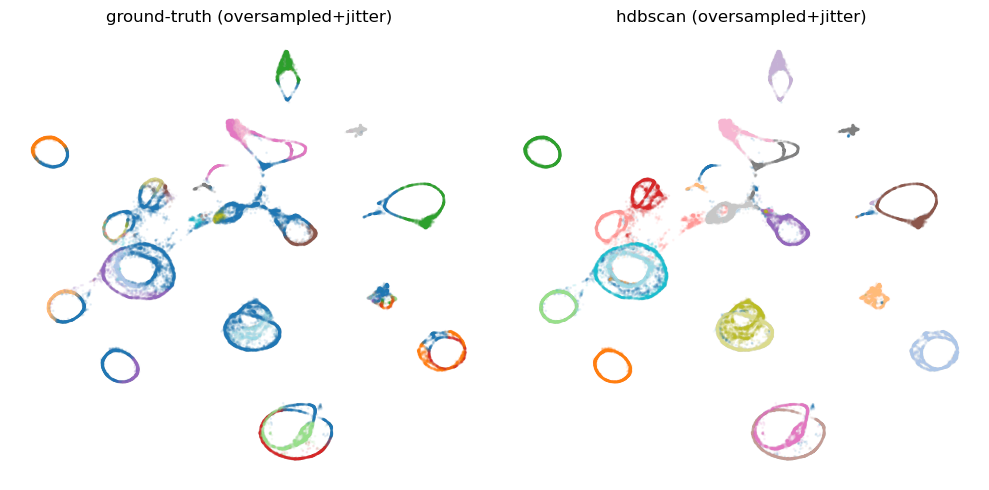

In [4]:
import numpy as np, umap, matplotlib.pyplot as plt
from math import ceil

# ── load ───────────────────────────────────────────────────────────────────────
f          = np.load("files/llb16_raw_false.npz")
X          = f["predictions"]
y_true     = f["ground_truth_labels"]
hdb_labels = f["hdbscan_labels"]

rng        = np.random.default_rng(42)

# ── oversample every HDB cluster to equal quota ───────────────────────────────
labels     = np.unique(hdb_labels)
n_classes  = len(labels)
per_class  = ceil(50_000 / n_classes)        # target rows per cluster

sel_X, sel_y, sel_hdb = [], [], []

for lbl in labels:
    pool = np.where(hdb_labels == lbl)[0]
    picks = rng.choice(pool, size=per_class, replace=len(pool) < per_class)

    # grab the originals
    sel_X.append(X[picks])
    sel_y.append(y_true[picks])
    sel_hdb.append(np.full(per_class, lbl))

# concat and trim back to 50 k
X_bal   = np.vstack(sel_X)[:50_000]
y_bal   = np.hstack(sel_y)[:50_000]
hdb_bal = np.hstack(sel_hdb)[:50_000]

# ── micro-jitter duplicates so they’re not exact copies ───────────────────────
eps     = 1e-3 * X.std(axis=0)               # per-dim scale
X_bal   = X_bal + rng.normal(0, eps, size=X_bal.shape)

# ── UMAP ──────────────────────────────────────────────────────────────────────
u       = umap.UMAP(
            n_neighbors=200,
            min_dist=0.1,
            metric="cosine",
            random_state=42
        )
x       = u.fit_transform(X_bal)

# ── viz ───────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x[:,0], x[:,1], c=y_bal,  cmap="tab20", s=1, alpha=0.08)
ax[0].set_title("ground-truth (oversampled+jitter)")
ax[0].axis("off")

ax[1].scatter(x[:,0], x[:,1], c=hdb_bal, cmap="tab20", s=1, alpha=0.08)
ax[1].set_title("hdbscan (oversampled+jitter)")
ax[1].axis("off")

plt.tight_layout(); plt.show()